<a href="https://colab.research.google.com/github/erichans/modularity-maximization/blob/main/Modularity_Maximization_Hybrid_Bat_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity
# from networkx.linalg.graphmatrix import adjacency_matrix
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.stats import norm
 
G = nx.karate_club_graph()

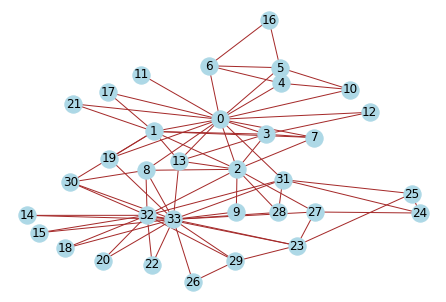

In [2]:
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color='lightblue', edge_color='brown', with_labels=True)

In [3]:
c = list(greedy_modularity_communities(G))
print(f'Found {len(c)} communities: \n{sorted(c)}')

Found 3 communities: 
[frozenset({32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}), frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21}), frozenset({0, 4, 5, 6, 10, 11, 16, 19})]


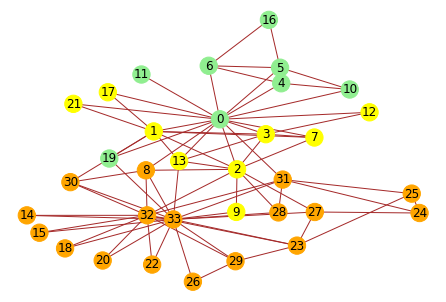

In [4]:
colors = ['orange', 'yellow', 'lightgreen', 'lightblue']

def get_color(label, communities):
    for index, community in enumerate(communities):
        if label in community:
            return colors[index]
    
nodes_color = [get_color(label, c) for label in G.nodes()]

nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=nodes_color, edge_color='brown', with_labels=True)

In [5]:
print(f'Total Nodes: {len(G.nodes())}')
print(f'Total Edges: {len(G.edges())}')

Total Nodes: 34
Total Edges: 78


In [6]:
baseline_communities = list(greedy_modularity_communities(G))
baseline = modularity(G, baseline_communities)
print(f'Modularity Baseline: {baseline}')

Modularity Baseline: 0.3806706114398422


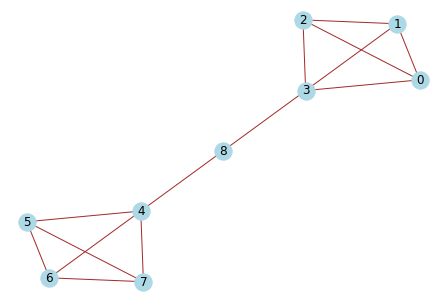

In [7]:
G2 = nx.Graph()
[G2.add_node(node) for node in range(9)]
G2.add_edge(0, 1)
G2.add_edge(0, 2)
G2.add_edge(0, 3)
G2.add_edge(1, 2)
G2.add_edge(1, 3)
G2.add_edge(2, 3)

# G2.add_edge(3, 4)

G2.add_edge(4, 5)
G2.add_edge(4, 6)
G2.add_edge(4, 7)
G2.add_edge(5, 6)
G2.add_edge(5, 7)
G2.add_edge(6, 7)

G2.add_edge(3, 8)
G2.add_edge(4, 8)
# G2.add_edge(4, 9)
# G2.add_edge(8, 9)

nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_color='lightblue', edge_color='brown', with_labels=True)

In [8]:
import random
import numpy as np
from networkx.algorithms.community.quality import modularity
from tqdm import tqdm_notebook

# lower frequencies for smaller ranges
class HybridBatAlgorithm:
    def __init__(self, graph, population_size, min_frequency, max_frequency, 
                 initial_loudness, alpha, initial_pulse_frequency, gamma,
                 num_iterations=10, seed=42):
        self.graph = graph
        self.random = random.Random(seed)
        np.seed = seed
        self.min_frequency = min_frequency
        self.max_frequency = max_frequency
        self.alpha = alpha
        self.initial_loudness = initial_loudness
        self.initial_pulse_frequency = initial_pulse_frequency
        self.gamma = gamma
        
        # locus-based adjacency representation
        self.valid_moves = {node:list(graph.neighbors(node)) for node in graph.nodes()}
#         print('valid_moves', valid_moves)
        
        self.bats = [Bat(self.graph, self.min_frequency, self.max_frequency, self.initial_loudness, self.initial_pulse_frequency, 
                         self.valid_moves , self.random) for _ in range(population_size)]
        self.num_iterations = num_iterations
        
    def find_current_best_bat(self):
        best_bat = None
        best_bat_fitness = -np.inf
        for bat in self.bats:
            if bat.fitness > best_bat_fitness:
                best_bat = bat
                best_bat_fitness = bat.fitness
                
        return best_bat
    
    def run(self):
        total_optimizations = 0
        best_bat = self.find_current_best_bat()
        # print('best bat improved', best_bat.fitness)
        
        # for iteration in tqdm_notebook(range(self.num_iterations)):
        for iteration in range(self.num_iterations):
            old_best_bat = best_bat
            best_bat = self.find_current_best_bat()
            # if best_bat.fitness > old_best_bat.fitness:
                # print('best bat improved', best_bat.fitness)
    #         print('best_bat', best_bat.position)
            for bat_index, bat in enumerate(self.bats):
                newBat = bat.move(best_bat.position)
                self.bats[bat_index] = newBat if newBat.fitness > bat.fitness else bat # nao tem no algoritmo original
                newBat = self.bats[bat_index]
            
                if self.random.uniform(0, 1) > newBat.pulse_frequency:
                    F = 0.3 # [0.1, 1.0]
                    CR = 0.5 # [0.1, 1.0]
                    bat1, bat2, bat3 = np.random.choice(len(self.bats), 3, replace=False)
                    bat1, bat2, bat3 = self.bats[bat1], self.bats[bat2], self.bats[bat3]
                    trial_bat_position = bat1.position + F * (bat2.position - bat3.position)
#                     for bat_index, bat in enumerate(self.bats):
                    trial_bat_position = np.array([-1] * len(bat.position))
                    for j in range(len(trial_bat_position)):
                        jrand = random.randint(0, len(self.bats) - 1)
#                         print('j', j, 'jrand', jrand, trial_bat_position, bat.position)
                        if random.uniform(0, 1) <= CR or j == jrand:
                            trial_bat_position[j] = bat1.position[j] + F * (bat2.position[j] - bat3.position[j])
                        else:
                            trial_bat_position[j] = bat.position[j]

                    trial_bat = Bat(self.graph, self.min_frequency, self.max_frequency, 
                                    self.initial_loudness, self.initial_pulse_frequency, self.valid_moves, self.random)
                    trial_bat.set_position(trial_bat_position)
                    if trial_bat.fitness >= bat.fitness:
                        self.bats[bat_index] = trial_bat
            #             Select a solution among the best solutions
            #             Generate a local solution around the best solution

            newBat = Bat(self.graph, self.min_frequency, self.max_frequency, self.initial_loudness, self.initial_pulse_frequency, 
                         self.valid_moves , self.random)
            for bat_index, bat in enumerate(self.bats):
                if self.random.uniform(0, 1) < bat.loudness and bat.fitness < newBat.fitness:
                    newBat.total_optimizations += 1
                    self.bats[bat_index] = newBat
                    newBat.loudness *= self.alpha
                    newBat.pulse_frequency = self.initial_pulse_frequency * (1 - np.exp(-GAMMA * newBat.total_optimizations))
    
class Bat:
    def __init__(self, graph, min_frequency, max_frequency, initial_loudness, initial_pulse_frequency, valid_moves, random):
        self.graph = graph
        self.random = random
        self.min_frequency = min_frequency
        self.max_frequency = max_frequency
        
        self.valid_moves = valid_moves
        
        self.set_position(np.array([self.random.randint(0, len(value) - 1) for key, value in self.valid_moves.items()]))
        self.velocity = np.zeros(shape=self.position.shape)
        self.frequency = np.zeros(shape=self.position.shape)
        
        self.loudness = self.initial_loudness = initial_loudness
        self.pulse_frequency = self.initial_pulse_frequency = initial_pulse_frequency
        self.total_optimizations = 0
#         self.fitness = modularity(self.graph, self.decode_communities())

    def move(self, best_bat_position):        
#         print('old position', self.position)
        newBat = Bat(self.graph, self.min_frequency, self.max_frequency, self.initial_loudness, self.initial_pulse_frequency, 
                         self.valid_moves , self.random)
        newBat.frequency = self.min_frequency + (self.max_frequency - self.min_frequency) * self.random.uniform(0, 1)
        newBat.velocity = self.velocity + (best_bat_position - self.position) * newBat.frequency # INVERTIDO DO ALGORITMO. Afasta do ponto do melhor ao invés de aproximar (?)
        newBat.set_position(self.position + newBat.velocity.astype(int))
        return newBat
    
    def set_position(self, position):
        self.position = position
        self.repair_position_boundaries()
        self.fitness = modularity(self.graph, self.decode_communities())
        
    def repair_position_boundaries(self): # between 0 and len(graph.neighbors(node))
        self.position = np.maximum(self.position, np.zeros(shape=self.position.shape)).astype(int)
        self.position = np.minimum(self.position, [len(connections) - 1 
                                                           for node, connections in self.valid_moves.items()]).astype(int)
#         if not np.all(self.position == repaired_position):
#             print('velocity', self.velocity)
#             print('position', self.position)
#             print('repaired_position', repaired_position)
    
    def decode_communities(self):
        g = [self.valid_moves[node][connection] for node, connection in enumerate(self.position)]
        
        current_cluster = 1
        cluster_assign = [-1] * len(g)
        previous = [-1] * len(g)
#         print('--------------------------------------------------------------------------')
        for i in range(len(g)):
            ctr = 1
#             print('1 previous', previous, 'ctr', ctr, 'neighbor', g[i], 'cluster_assign', cluster_assign, 'g', g)
            if cluster_assign[i] == -1:
                cluster_assign[i] = current_cluster
                neighbor = g[i]
                previous[ctr] = i
                ctr += 1
                while cluster_assign[neighbor] == -1:
#                     if ctr < 0 or ctr >= len(previous):
#                     print('2 previous', previous, 'ctr', ctr, 'neighbor', neighbor, 'cluster_assign', cluster_assign, 'g', g)
                    previous[min(ctr, len(previous) - 1)] = neighbor
                    cluster_assign[neighbor] = current_cluster
                    neighbor = g[neighbor]
                    ctr += 1
                if cluster_assign[neighbor] != current_cluster:
                    ctr -= 1
                    while ctr >= 1:
#                         print('3 previous', previous, 'ctr', ctr, 'neighbor', neighbor,  'cluster_assign', cluster_assign, 'g', g)
                        cluster_assign[previous[ctr]] = cluster_assign[neighbor]
                        ctr -= 1
                else:
                    current_cluster += 1

        community_number = 1
        communities = []
#         print('current_cluster', current_cluster, 'cluster_assign', cluster_assign)
        for index, element in enumerate(cluster_assign):
            if element > len(communities):
                communities.append([])
            communities[element-1].append(index)
            
        return communities  

In [9]:
POPULATION_SIZE = 30 # 40 original paper 10 to 250 - for most problems, 15 to 50 is sufficient - (original bat)
DIMENSION_SIZE = len(G.nodes())
NUM_ITERATIONS = 20 # original paper DIMENSION_SIZE * 100
Q_MIN_FREQUENCY = 0
Q_MAX_FREQUENCY = 2
A_LOUDNESS = 0.5 # hybrid bat paper
ALPHA = 0.9 # (original bat paper) is similar to the cooling factor of a cooling schedule in the simulated annealing
R0_PULSE_FREQUENCY = 0.5 # hybrid bat paper
GAMMA = 0.9 # (original bat paper) 
OPTIMIZATION_COUNT = 0
SEED = 42

In [10]:
hbat = HybridBatAlgorithm(graph=G, population_size=POPULATION_SIZE, 
                          min_frequency=Q_MIN_FREQUENCY, max_frequency=Q_MAX_FREQUENCY, 
                          initial_loudness=A_LOUDNESS, alpha=ALPHA, 
                          initial_pulse_frequency=R0_PULSE_FREQUENCY, gamma=GAMMA,
                          num_iterations=20, seed=SEED)
hbat.run()
hbat.find_current_best_bat().fitness

0.41978961209730437

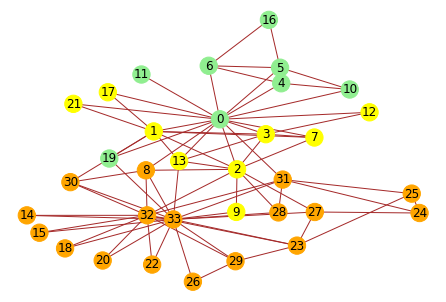

In [11]:
nodes_color = [get_color(label, c) for label in G.nodes()]
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=nodes_color, edge_color='brown', with_labels=True)

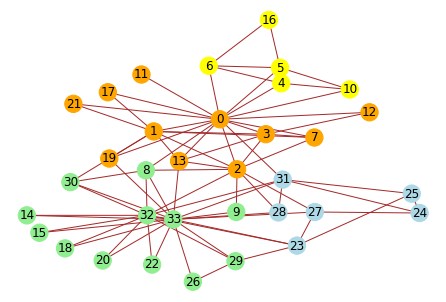

In [12]:
communities = hbat.find_current_best_bat().decode_communities()
nodes_color = [get_color(label, communities) for label in G.nodes()]

nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=nodes_color, edge_color='brown', with_labels=True)

In [13]:
def run_find_best_bat(graph):
  hbat = HybridBatAlgorithm(graph=graph, population_size=POPULATION_SIZE, 
                          min_frequency=Q_MIN_FREQUENCY, max_frequency=Q_MAX_FREQUENCY, 
                          initial_loudness=A_LOUDNESS, alpha=ALPHA, 
                          initial_pulse_frequency=R0_PULSE_FREQUENCY, gamma=GAMMA,
                          num_iterations=20, seed=SEED)
  hbat.run()
  return hbat.find_current_best_bat().fitness


In [14]:
total_execucoes_tempo = 100

In [15]:
acumulado_karate = []

In [16]:
tempo1 = timeit.repeat(lambda: acumulado_karate.append(run_find_best_bat(G)), number=1, repeat=total_execucoes_tempo)
total_amostras1 = len(tempo1)
media1 = np.mean(tempo1)
desvio_padrao1 = np.std(tempo1)
print('quantidade de amostras', total_amostras1, 'média', media1, 'desvio padrão', desvio_padrao1)

quantidade de amostras 100 média 0.556542125549987 desvio padrão 0.016185492981341757


In [17]:
total_amostras1_execucao = len(acumulado_karate)
media1_execucao = np.mean(acumulado_karate)
desvio_padrao1_execucao = np.std(acumulado_karate)
print('quantidade de amostras de resultado', total_amostras1_execucao, 'média', media1_execucao, 'desvio padrão', desvio_padrao1_execucao)

quantidade de amostras de resultado 100 média 0.4181977317554241 desvio padrão 0.0036612708278286965


In [18]:
intervalo_confianca1 = .99
alfa1 = 1 - intervalo_confianca1 # significância

valor_normal_inicio1 = norm.ppf(alfa1 / 2)
valor_normal_fim1 = norm.ppf(intervalo_confianca1 + alfa1 / 2)

minimo_teste1 = media1 + valor_normal_inicio1 * desvio_padrao1 / np.sqrt(total_amostras1)
maximo_teste1 = media1 + valor_normal_fim1 * desvio_padrao1 / np.sqrt(total_amostras1)

print(f'Intervalo de Confiança para {intervalo_confianca1 * 100:.0f}%: ({minimo_teste1:.2f}, {maximo_teste1:.2f}) segundos')

Intervalo de Confiança para 99%: (0.55, 0.56) segundos


In [19]:
intervalo_confianca1_execucao = .99
alfa1_execucao = 1 - intervalo_confianca1_execucao # significância

valor_normal_inicio1_execucao = norm.ppf(alfa1_execucao / 2)
valor_normal_fim1_execucao = norm.ppf(intervalo_confianca1_execucao + alfa1_execucao / 2)

minimo_teste1_execucao = media1_execucao + valor_normal_inicio1_execucao * desvio_padrao1_execucao / np.sqrt(total_amostras1_execucao)
maximo_teste1_execucao = media1_execucao + valor_normal_fim1_execucao * desvio_padrao1_execucao / np.sqrt(total_amostras1_execucao)

print(f'Intervalo de Confiança da modularidade encontrada {intervalo_confianca1_execucao * 100:.0f}%: ({minimo_teste1_execucao:.4f}, {maximo_teste1_execucao:.4f})')

Intervalo de Confiança da modularidade encontrada 99%: (0.4173, 0.4191)


In [20]:
acumulado_basico = []

In [21]:
tempo2 = timeit.repeat(lambda: acumulado_basico.append(run_find_best_bat(G2)), number=1, repeat=total_execucoes_tempo)
total_amostras2 = len(tempo2)
media2 = np.mean(tempo2)
desvio_padrao2 = np.std(tempo2)
print('quantidade de amostras', total_amostras2, 'média', media2, 'desvio padrão', desvio_padrao2)

quantidade de amostras 100 média 0.23213982249999845 desvio padrão 0.007910282963076339


In [22]:
total_amostras2_execucao = len(acumulado_basico)
media2_execucao = np.mean(acumulado_basico)
desvio_padrao2_execucao = np.std(acumulado_basico)
print('quantidade de amostras de resultado', total_amostras2_execucao, 'média', media2_execucao, 'desvio padrão', desvio_padrao2_execucao)

quantidade de amostras de resultado 100 média 0.4260204081632654 desvio padrão 5.551115123125783e-17


In [23]:
intervalo_confianca2 = .99
alfa2 = 1 - intervalo_confianca2 # significância

valor_normal_inicio2 = norm.ppf(alfa2 / 2)
valor_normal_fim2 = norm.ppf(intervalo_confianca2 + alfa2 / 2)

minimo_teste2 = media2 + valor_normal_inicio2 * desvio_padrao2 / np.sqrt(total_amostras2)
maximo_teste2 = media2 + valor_normal_fim2 * desvio_padrao2 / np.sqrt(total_amostras2)

print(f'Intervalo de Confiança para {intervalo_confianca2 * 100:.0f}%: ({minimo_teste2}, {maximo_teste2}) segundos')

Intervalo de Confiança para 99%: (0.2301022686344329, 0.23417737636556402) segundos


In [24]:
intervalo_confianca2_execucao = .99
alfa2_execucao = 1 - intervalo_confianca2_execucao # significância

valor_normal_inicio2_execucao = norm.ppf(alfa2_execucao / 2)
valor_normal_fim2_execucao = norm.ppf(intervalo_confianca2_execucao + alfa2_execucao / 2)

minimo_teste2_execucao = media2_execucao + valor_normal_inicio2_execucao * desvio_padrao2_execucao / np.sqrt(total_amostras2_execucao)
maximo_teste2_execucao = media2_execucao + valor_normal_fim2_execucao * desvio_padrao2_execucao / np.sqrt(total_amostras2_execucao)

print(f'Intervalo de Confiança da modularidade encontrada {intervalo_confianca2_execucao * 100:.0f}%: ({minimo_teste2_execucao}, {maximo_teste2_execucao})')

Intervalo de Confiança da modularidade encontrada 99%: (0.4260204081632654, 0.4260204081632654)


In [25]:
import community as community_louvain

partition = community_louvain.best_partition(G)
# print(partition)
community_number = 0
communities = []

for _ in range(max(partition.values()) + 1):
    communities.append([])

for index, element in partition.items():
    communities[element].append(index)

modularity(G, communities)

0.41880341880341876

20


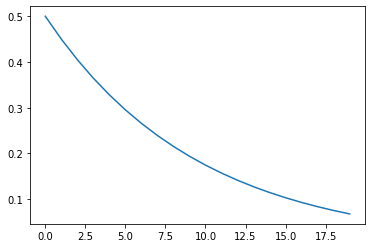

In [26]:
print(NUM_ITERATIONS)
x = np.arange(NUM_ITERATIONS)
y = A_LOUDNESS*(ALPHA**x)

limit = 500
plt.plot(x[:limit], y[:limit])


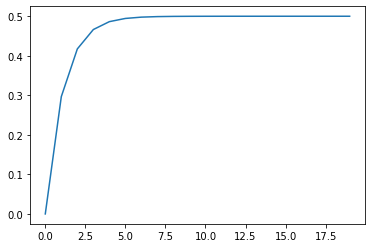

In [27]:

R_PULSE_FREQUENCY = R0_PULSE_FREQUENCY * (1 - np.exp(-GAMMA*x))

limit = 50
plt.plot(x[:limit], R_PULSE_FREQUENCY[:limit])